In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from numpy import ndarray
from dataclasses import dataclass
from typing import Literal, Union, List

In [2]:
@dataclass
class PanoVisItem:
    perspective: ndarray = None
    mask: ndarray = None

In [3]:
class PanoramaUtil:

    @classmethod
    def xyz_to_geo(cls,
                      xyz: ndarray) -> ndarray:
        atan2 = np.arctan2
        asin = np.arcsin

        norm = np.linalg.norm(xyz, axis=-1, keepdims=True)
        xyz_norm = xyz / norm
        x = xyz_norm[..., 0:1]
        y = xyz_norm[..., 1:2]
        z = xyz_norm[..., 2:]

        lon = atan2(x, z)
        lat = asin(y)
        lst = [lon, lat]

        out = np.concatenate(lst, axis=-1)
        return out

    @classmethod
    def geo_to_xy(cls,
                  geo: ndarray,
                  shape: tuple) -> ndarray:
        x = (geo[..., 0:1] / (2 * np.pi) + 0.5) * (shape[1] - 1)
        y = (geo[..., 1:] / np.pi + 0.5) * (shape[0] - 1)
        lst = [x, y]
        out = np.concatenate(lst, axis=-1)

        return out


In [4]:
class PanoData:

    def __init__(self,
                 file: Union[Path, str],
                 heading: float,
                 mode: Literal["baidu", "google"]):

        # to support chinese file path
        with open(file, "rb") as f:
            image_bytes =  np.frombuffer(f.read(), np.uint8)

        self._img = cv2.imdecode(image_bytes, cv2.IMREAD_COLOR)
        assert self._img is not None

        self._shape = self._img.shape
        if len(self._shape) == 3:
            self._height, self._width, self._channel = self._shape
        else:
            self._height, self._width = self._shape
            self._channel = 1

        self._heading = heading - 90 if mode == "baidu" else heading
        self._mode = mode

    @property
    def width(self) -> int:
        return self._width

    @property
    def height(self) -> int:
        return self._height

    @property
    def channel(self) -> int:
        return self._channel

    @property
    def img(self) -> ndarray:
        return self._img

    def plot_view(self,
                  xy: ndarray) -> ndarray:
        overlay = self._img.copy()
        if abs((xy[0, -1] - xy[0, 0])[0].item()) > self._width / 2:
            corners1 = np.array([
                [0, xy[0, -1][1].item()],
                xy[0, -1],
                xy[-1, -1],
                [0, xy[-1, -1][1].item()]
            ], np.int32)

            corners2 = np.array([
                [self._width, xy[0, 1][1].item()],
                xy[0, 0],
                xy[-1, 0],
                [self._width, xy[-1, 0][1].item()]
            ], np.int32)

            cv2.polylines(overlay, [corners1, corners2], isClosed=True, color=(0, 255, 0), thickness=20)

        else:
            corners = np.array([
                xy[0, 0],
                xy[0, -1],
                xy[-1, -1],
                xy[-1, 0]
            ], np.int32)
            cv2.polylines(overlay, [corners], isClosed=True, color=(0, 255, 0), thickness=20)

        return overlay

    def get_perspective(self,
                        fov: int = 120,
                        theta: float = 0.0,
                        updown: int = 0,
                        height: int = 512,
                        width: int = 1024) -> PanoVisItem:
        """
        :param fov:
        :param theta:  THETA is left/right angle
        :param updown: up/down angle, both in degree
        :param height:
        :param width:
        :return:
        """

        f = 0.5 * width * 1 / np.tan(0.5 * fov / 180.0 * np.pi)
        cx = (width - 1) / 2.0
        cy = (height - 1) / 2.0
        k = np.array([
            [f, 0, cx],
            [0, f, cy],
            [0, 0, 1],
        ], np.float32)
        k_inv = np.linalg.inv(k)

        x = np.arange(width)
        y = np.arange(height)
        x, y = np.meshgrid(x, y)
        z = np.ones_like(x)
        xyz = np.concatenate([x[..., None], y[..., None], z[..., None]], axis=-1)
        xyz = xyz @ k_inv.T

        y_axis = np.array([0.0, 1.0, 0.0], np.float32)
        x_axis = np.array([1.0, 0.0, 0.0], np.float32)
        r1, _ = cv2.Rodrigues(y_axis * np.radians(theta - self._heading))
        r2, _ = cv2.Rodrigues(np.dot(r1, x_axis) * np.radians(updown))
        r = r2 @ r1
        xyz = xyz @ r.T
        lonlat = PanoramaUtil.xyz_to_geo(xyz)
        xy = PanoramaUtil.geo_to_xy(lonlat, shape=self._shape).astype(np.float32)
        perspective = cv2.remap(self._img, xy[..., 0], xy[..., 1], cv2.INTER_CUBIC, borderMode=cv2.BORDER_WRAP)

        return PanoVisItem(
            perspective,
            self.plot_view(xy)
        )

    def get_multi_directions(self,
                             n: int,
                             fov: int = 120,
                             updown: int = 0,
                             height: int = 512,
                             width: int = 1024) -> List[ndarray]:
        if n <= 1:

            return [self.get_perspective(
                fov=fov,
                theta=0.0, 
                updown=updown,
                height=height,
                width=width
            ).perspective]

        directions = []
        for i in range(n):
            theta = i * (360.0 / n)
            vis_item = self.get_perspective(
                fov=fov,
                theta=theta,
                updown=updown,
                height=height,
                width=width
            )
            directions.append(vis_item.perspective)
        return directions

In [5]:
data = PanoData("data/google/00000000.jpg", heading=179.0723572, mode="google")
data

In [6]:
directions = data.get_multi_directions(6)
len(directions)

6

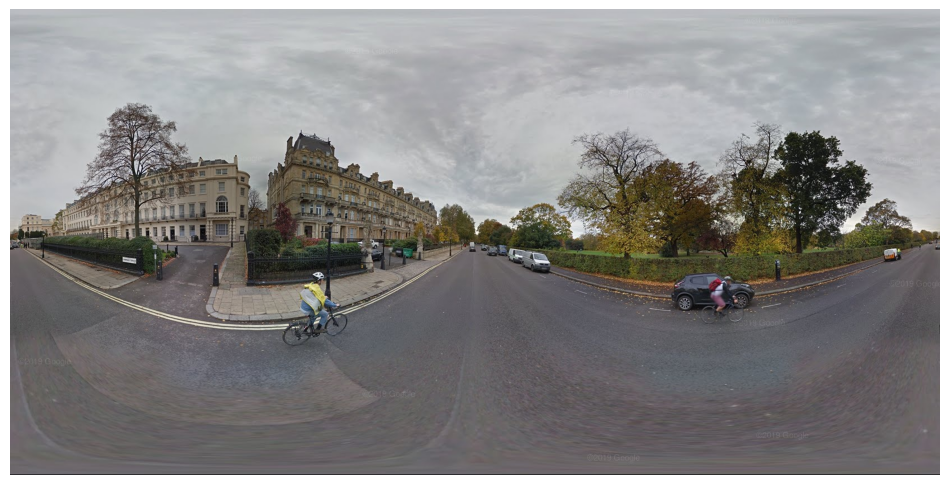

In [7]:
plt.figure(figsize=(12,8))
plt.imshow(cv2.cvtColor(data.img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

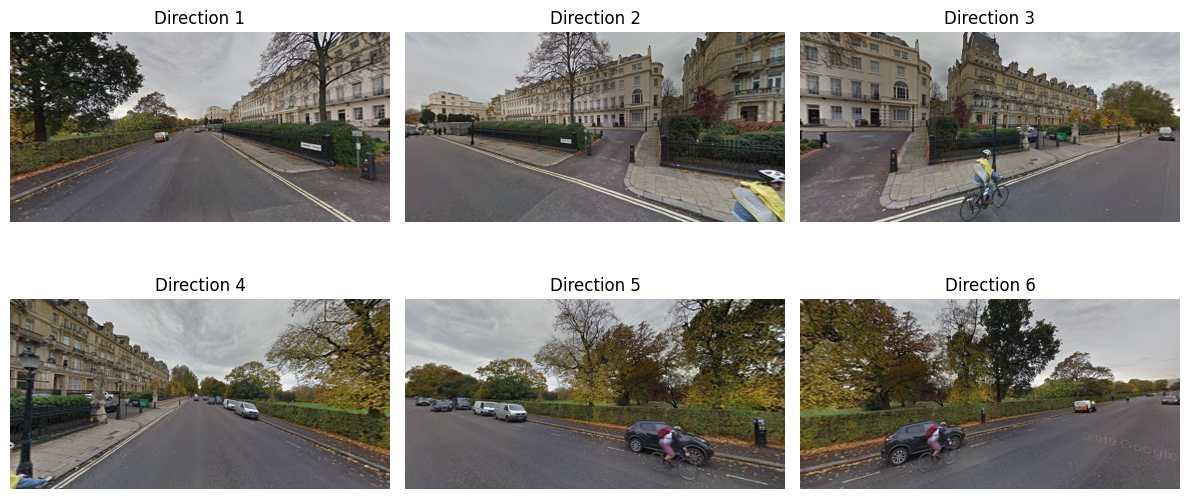

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6)) 

for i, ax in enumerate(axes.flat):
    ax.imshow(directions[i][:,:,::-1])
    ax.set_title(f"Direction {i+1}")
    ax.axis('off')  

plt.tight_layout()
plt.show()

## The following code requires the installation of mmcv and mmsegmentation.

In [9]:
import torch, numpy as np
print('torch:', torch.__version__)
print('numpy:', np.__version__)
print('cuda?', torch.cuda.is_available())
print('mps?', hasattr(torch.backends, 'mps') and torch.backends.mps.is_available())

torch: 2.2.2
numpy: 1.26.4
cuda? False
mps? False


!python -m mim download mmsegmentation --config ocrnet_hr48_4xb2-40k_cityscapes-512x1024 --dest .

In [10]:
import os
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from mmseg.apis import inference_model, init_model

In [11]:
from pathlib import Path

cfg_path = Path("data/ocrnet/ocrnet_hr48_4xb2-40k_cityscapes-512x1024.py")
ckpt_path = Path("data/ocrnet/ocrnet_hr48_512x1024_40k_cityscapes_20200601_033336-55b32491.pth")

print(cfg_path.resolve())  # 打印绝对路径，确认找得到
print(cfg_path.exists(), ckpt_path.exists())  # True 就说明能找到

config_file = str(cfg_path)
checkpoint_file = str(ckpt_path)

model = init_model(config_file, checkpoint_file, device="cpu")


/Users/sue/Documents/CASA/CASA0004/github/data/ocrnet/ocrnet_hr48_4xb2-40k_cityscapes-512x1024.py
True True
Loads checkpoint by local backend from path: data/ocrnet/ocrnet_hr48_512x1024_40k_cityscapes_20200601_033336-55b32491.pth


config_file = "/Users/sue/Documents/CASA/data/ocrnet/ocrnet_hr48_4xb2-40k_cityscapes-512x1024.py"
checkpoint_file = "/Users/sue/Documents/CASA/data/ocrnet/ocrnet_hr48_512x1024_40k_cityscapes_20200601_033336-55b32491.pth"

model = init_model(config_file, checkpoint_file, device='cpu')

In [12]:
GREEN_CLASS_IDS = {8}
def calculate_green_index_batch(results):
    indices = []
    for res in results:
        seg = res.pred_sem_seg.data.cpu().numpy()
        if isinstance(seg, list):
            seg = seg[0]
        total = seg.size
        green = sum((seg == cid).sum() for cid in GREEN_CLASS_IDS)
        indices.append(green / total if total > 0 else 0.0)
    return indices

In [13]:
results = inference_model(model, directions)
green_scores_all = calculate_green_index_batch(results)
green_scores_all

[0.3662281036376953,
 0.23781204223632812,
 0.12057876586914062,
 0.3372383117675781,
 0.4958839416503906,
 0.43981361389160156]